# Quantile Regressions

This notebook illustrates quantile regressions.

As an alternative, consider the [QuantileRegressions.jl](https://github.com/pkofod/QuantileRegressions.jl) package.

## Load Packages and Extra Functions

The key function used in this notebook `QuantRegrIRLS()` is from the (local) `FinEcmt_OLS` module.

In [1]:
MyModulePath = joinpath(pwd(),"jlFiles")
!in(MyModulePath,LOAD_PATH) && push!(LOAD_PATH,MyModulePath);

In [2]:
using FinEcmt_OLS, DelimitedFiles, Statistics

In [3]:
using Plots
default(size = (480,320),fmt = :png)

## Loading Data

In [4]:
xx  = readdlm("Data/FFdFactors.csv",',',skipstart=1)
xx  = xx[:,2]            #equity market excess returns

y = xx[2:end]            #dependent variable
x = xx[1:end-1]          #regressor in an AR(1)

T   = size(y,1)
println("Sample size: $T")

Sample size: 15355


## A Function for Quantile Regressions

The `QuantRegrIRLS()` function from the `FinEcmt_OLS` estimates a quantile regression. It uses a simple iterative (re-)weighted least squares (IRLS) approach. It can be shown that a linear programming approach gives almost identical results for this data set. However, it seems that the iterative approach is quicker in really large data sets. The function returns several different calculations of the standard errors: see the code below and the lecture notes for details.

The subsequent cells calculate and show the results. The calculations take some time.

### A Remark on the Code
- The arrays in the iteration are pre-allocated and then the new results overwrite the old ones, in an attempt to decrease the memory usage.

In [5]:
@doc2 QuantRegrIRLS

```
QuantRegrIRLS(y,x,q=0.5;prec=1e-8,epsu=1e-6,maxiter=1000)
```

Estimate a quantile regression for quantile `q`. The outputs are the point estimates and three different variance-covariance matrices of the estimates.

### Input

  * `y::Vector`:     T vector, dependent variable
  * `x::VecOrMat`:   TXK, regressors (including any constant)
  * `q::Number`:     quantile to estimate at, 0<q<1
  * `prec::Float64`: convergence criterion, 1e-8
  * `epsu::Float64`: lower bound on 1/weight, 1e-6
  * `maxiter::Int`:  maximum number of iterations, 1000

### Output

  * `theta::Vector`: K vector, estimated coefficients
  * `vcv::Matrix`:   KxK, traditional covariance matrix
  * `vcv2::Matrix`:  KxK, Powell (1991) covariance matrix
  * `vcv3::Matrix`:  KxK, Powell (1991) covariance matrix, uniform

### Remarks

1. `while maximum(abs,b - b_old) > prec ...end` creates a loop that continues as long as  the new and previous estimates differ more than `prec`. However, once the number of  iterations exceed `maxiter` then the execution is stopped.
2. `u .= max.(u,epsu)` limits how small `u` can become which makes the algorithm more stable (recall: the next command is `x./u`).


In [6]:
#using CodeTracking
#println(@code_string QuantRegrIRLS([1],[1],0.05))

In [7]:
xGrid = quantile(x,0.01:0.01:0.99)                 #quantiles of the regressor, for plots
xGrid = [ones(size(xGrid)) xGrid]

qM = [0.01,0.05,0.25,0.5,0.75,0.95,0.99]           #quantiles

cx = [ones(T) x]                                   #[constant regressors]

bM    = fill(NaN,length(qM),2)                     #to store regression coeffs
qPred = fill(NaN,length(qM),size(xGrid,1))         #to store predicted values
for i = 1:length(qM)
    #local b_q
    b_q        = QuantRegrIRLS(y,cx,qM[i])[1]
    bM[i,:]    = b_q
    qPred[i,:] = xGrid*b_q
end

printblue("quantile regression coefs:\n")
printmat(bM;colNames=["c","slope"],rowNames=string.(qM),cell00="quantile")

printred("\nThe function QuantRegrIRLS also outputs different variance-covariance matrices. Compare them.")

quantile regression coefs:

quantile         c     slope
0.01        -2.568     0.139
0.05        -1.433     0.158
0.25        -0.410     0.146
0.5          0.047     0.067
0.75         0.477     0.024
0.95         1.409    -0.028
0.99         2.582    -0.188


The function QuantRegrIRLS also outputs different variance-covariance matrices. Compare them.


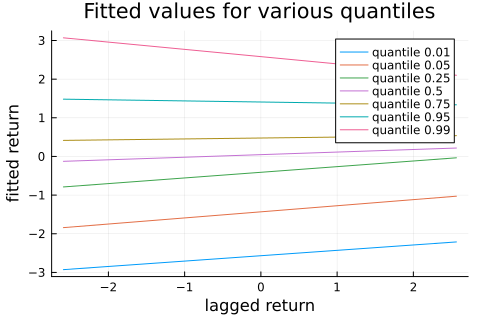

In [8]:
lab = permutedims(["quantile $(qM[i])" for i=1:length(qM)])

p1 = plot( xGrid[:,2],qPred',
           label = lab,
           xlabel = "lagged return",
           ylabel = "fitted return",
           title = "Fitted values for various quantiles" )
display(p1)